In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0

In [0]:
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

In [0]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import keras
import h5py
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
from keras.layers import *
from keras.preprocessing import image
from keras.layers.core import Dropout, Lambda
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Add, Flatten, UpSampling2D, BatchNormalization
from keras.layers import Dense, Activation, Flatten, Dropout, concatenate, Input
from keras.optimizers import Adam, Adadelta
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU
#from keras.layers.convolutional import Deconvolution2D
from keras.metrics import categorical_accuracy
from keras import optimizers

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
cd /content/drive/My Drive/data

/content/drive/My Drive/data


In [0]:
!ls

-00001.png	   masks		    RailwaySeg.ipynb
-01501_object.png  model.png		    semantic_segmentation_zoo
-01501.png	   newimage1.png	    tools
camera_cal	   NewMasks		    train_frames
class_dict.csv	   pretrained_weights	    training
data_provider	   project_video.mp4	    train_masks
DeepLab.ipynb	   RailTracksProject.ipynb  UnetSegmentation.ipynb
label_colors.txt   Railway.ipynb	    val_frames
logs		   RailwayNew.ipynb	    val_masks


In [0]:
path_train_images = '/content/drive/My Drive/data/train_frames/train/'
path_train_annotations = '/content/drive/My Drive/data/NewMasks/Train_Mask/'

path_val_images = '/content/drive/My Drive/data/val_frames/val/'
path_val_annotations = '/content/drive/My Drive/data/NewMasks/Val_Mask/'

In [0]:
IMAGE_HEIGHT = 400 
IMAGE_WIDTH = 400

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import re
from PIL import Image
import json


import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import os
import sys
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *


#from tensorflow.keras.engine import Layer
from tensorflow.keras.applications.vgg16 import *
from tensorflow.keras.models import *
#from tensorflow.keras.applications.imagenet_utils import _obtain_input_shape
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Cropping2D, Conv2D
from tensorflow.keras.layers import Input, Add, Dropout, Permute, add
from tensorflow.compat.v1.layers import conv2d_transpose
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [0]:
import cv2

In [0]:
seed = 1

In [0]:
DATA_PATH = '/content/drive/My Drive/data/'

In [0]:
import itertools    

In [0]:
from skimage import morphology

In [0]:
HEIGHT = 224
WIDTH = 224

In [0]:
labels = [0, 255]

In [0]:
# Functions to be used during Image Augumentation
def random_brightness(image):
    # Convert 2 HSV colorspace from BGR colorspace
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Generate new random brightness
    rand = random.uniform(0.3, 1.0)
    hsv[:, :, 2] = rand*hsv[:, :, 2]
    # Convert back to BGR colorspace
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return new_img

# Zoom-in
def zoom(image):
    zoom_pix = random.randint(0, 10)
    zoom_factor = 1 + (2*zoom_pix)/IMAGE_HEIGHT
    image = cv2.resize(image, None, fx=zoom_factor,
                       fy=zoom_factor, interpolation=cv2.INTER_LINEAR)
    top_crop = (image.shape[0] - IMAGE_HEIGHT)//2
    left_crop = (image.shape[1] - IMAGE_WIDTH)//2
    image = image[top_crop: top_crop+IMAGE_HEIGHT,
                  left_crop: left_crop+IMAGE_WIDTH]
    return image

In [0]:
def generator(
    image_path, mask_path, batch_size, input_height, input_width, labels, is_train
):

    assert image_path[-1] == "/"
    assert mask_path[-1] == "/"

    images = glob.glob(image_path + "*.png")
    segmentations = glob.glob(mask_path + "*.png")
    images.sort()
    segmentations.sort()

    assert len(images) == len(segmentations)

   

    zipped = itertools.cycle(zip(images, segmentations))

    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            im, seg = next(zipped)
            # reading image
            img = cv2.imread(im)[:, :, ::-1]
            img1 = cv2.imread(seg, 0)
            should_augment = random.randint(0, 1)
            if is_train == 1:
                if should_augment:
                    should_chng_brightness = random.randint(0, 1)
                    should_flip = random.randint(0, 1)
                    should_zoom = random.randint(0, 1)
                    if should_flip == 1:
                        img = cv2.flip(img, 1)
                        img1 = cv2.flip(img1, 1)
                    elif should_zoom == 1:
                        img = zoom(img)
                        img1 = zoom(img1)
                    elif should_chng_brightness == 1:
                        img = random_brightness(img)
            img = cv2.resize(
                img, (input_width, input_height), interpolation=cv2.INTER_NEAREST
            )
            # Scaling the input image
            img = img.astype(np.float32)
            img = img / 255.0

            X.append(img)

            img1 = cv2.resize(
                img1, (input_width, input_height), interpolation=cv2.INTER_NEAREST
            )
            seg_labels = np.zeros((input_height, input_width, len(labels)))

            # Transforming into binary
            for c, l in enumerate(labels):
                seg_labels[:, :, c] = ((img1 == l)) * 1

            seg_labels = seg_labels.astype(np.float32)
            Y.append(seg_labels)

        yield np.array(X), np.array(Y)

In [0]:
train_gen = generator('/content/drive/My Drive/data/train_frames/train/','/content/drive/My Drive/data/NewMasks/Train_Mask/' ,
               1, 224,224,labels, 1)

In [0]:
import random

In [0]:
import glob

In [0]:
a, b = next(train_gen)

In [0]:
a.shape

(1, 224, 224, 3)

In [0]:
b.shape

(1, 224, 224, 2)

(-0.5, 223.5, 223.5, -0.5)

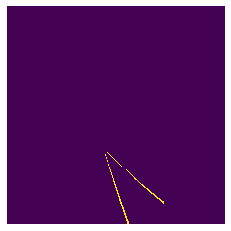

In [0]:
plt.imshow(b[0].argmax(axis=2) * 255)
plt.axis('off')

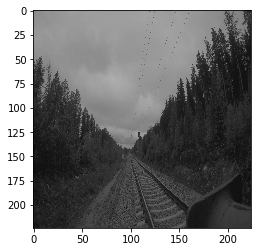

In [0]:
plt.imshow(a[0])

In [0]:
valid_gen = generator('/content/drive/My Drive/data/val_frames/val/','/content/drive/My Drive/data/NewMasks/Val_Mask/' ,
               5, 224,224,labels, 0)

In [0]:
d,e=next(valid_gen)

In [0]:
d.shape

(5, 224, 224, 3)

In [0]:
e.shape

(5, 224, 224, 2)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as Img
import os
from PIL import Image
import glob
import shutil
from random import randint
from random import shuffle
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
from skimage import morphology
import numpy as np
import cv2
import glob
import itertools
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D
from keras.layers import Input, Add, Dropout, Permute, add, Activation
from scipy.io import loadmat
import tensorflow as tf
import numpy as np
from keras.optimizers import Adam, RMSprop
from keras.metrics import categorical_crossentropy,binary_crossentropy
from threading import Thread
import time
from keras import backend as K
import tensorflow as tf
import numpy as np
from keras.models import Sequential,Model
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, Deconvolution2D, Cropping2D, Conv2DTranspose, UpSampling2D
from keras.layers import Input, Add, Dropout, Permute, add, concatenate, Reshape, Activation, BatchNormalization
from scipy.io import loadmat
from keras.layers.advanced_activations import PReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D, ZeroPadding2D
from keras.layers.core import SpatialDropout2D, Permute, Activation, Reshape
from keras.layers.merge import add, concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.engine.topology import Input
from keras.models import Model
#from crfrnn_layer import CrfRnnLayer

from keras.preprocessing.image import ImageDataGenerator, load_img

from keras.models import *
from keras.layers import *

In [0]:
def downsample_bottleneck(o, output_size, asymmetric=0, dilated=0, downsample=0):

    second_branch = o
    input_n_channels = o.get_shape().as_list()[3]
    padding = output_size - input_n_channels

    # reducing the channels (1x1)
    if downsample:
        stride = 2
    else:
        stride = 1

    o = Conv2D(
        output_size // 4, (stride, stride), strides=(stride, stride), use_bias=False
    )(o)
    o = BatchNormalization(momentum=0.1)(o)
    o = PReLU(shared_axes=[1, 2])(o)

    # Perfroming convolution (COnv)
    if asymmetric:
        o = Conv2D(output_size // 4, (1, asymmetric), padding="same", use_bias=False)(o)
        o = Conv2D(output_size // 4, (asymmetric, 1), padding="same")(o)
    else:
        if dilated:
            o = Conv2D(
                output_size // 4,
                (3, 3),
                dilation_rate=(dilated, dilated),
                padding="same",
            )(o)
        else:
            o = Conv2D(output_size // 4, (3, 3), padding="same")(o)

    o = BatchNormalization(momentum=0.1)(o)
    o = PReLU(shared_axes=[1, 2])(o)

    # Producing back the channels (1x1)
    o = Conv2D(output_size, (1, 1), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o)

    # Performing regularization (Regularizer)
    o = SpatialDropout2D(0.1)(o)

    # Second branch

    # performing max pooling only if downsample
    if downsample:
        second_branch = MaxPooling2D()(second_branch)

        # performing padding -- only required if downsampling
        second_branch = Permute((1, 3, 2))(second_branch)
        second_branch = ZeroPadding2D(padding=((0, 0), (0, padding)))(second_branch)
        second_branch = Permute((1, 3, 2))(second_branch)

    o = add([o, second_branch])
    o = PReLU(shared_axes=[1, 2])(o)

    return o

In [0]:
def upsample_bottleneck(o, output_size, upsample=0):

    other_branch = o

    # reducing the number of channel by 1x1 convolution
    o = Conv2D(output_size // 4, (1, 1), use_bias=False)(o)
    o = BatchNormalization(momentum=0.1)(o)
    o = Activation("relu")(o)

    # Perfroming upsmapling if asked for otherwise performing normal convolution operation
    if upsample:
        o = Conv2DTranspose(
            output_size // 4, kernel_size=(3, 3), strides=(2, 2), padding="same"
        )(o)
    else:
        o = Conv2D(output_size // 4, (3, 3), padding="same", use_bias=True)(o)

    o = BatchNormalization(momentum=0.1)(o)
    o = Activation("relu")(o)

    # Producing back the channels
    o = Conv2D(output_size, (1, 1), padding="same", use_bias=False)(o)

    # Upsampling the other branch as well if upsampling is required
    if upsample:
        other_branch = Conv2D(output_size, (1, 1), padding="same", use_bias=False)(
            other_branch
        )
        other_branch = BatchNormalization(momentum=0.1)(other_branch)
        other_branch = UpSampling2D(size=(2, 2))(other_branch)

    # Adding the two branches
    o = BatchNormalization(momentum=0.1)(o)
    o = add([o, other_branch])
    o = Activation("relu")(o)

    return o

In [0]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *


def ENet(n_classes, input_height, input_width, channels):

    # defining teh Input size
    img_input = Input(shape=(input_height, input_width, channels))

    ## Section Initial
    conv = Conv2D(13, (3, 3), padding="same", strides=(2, 2))(img_input)
    max_pool = MaxPooling2D()(img_input)
    merged = concatenate([conv, max_pool], axis=3)
    o = BatchNormalization(momentum=0.1)(merged)
    o = PReLU(shared_axes=[1, 2])(o)
    ### Section Initial End

    ##Section 2 and 3
    o = downsample_bottleneck(o, 64, downsample=True)  # 1.1

    for _ in range(4):  # 1.2-1.5
        o = downsample_bottleneck(o, 64)

    o = downsample_bottleneck(o, 128, downsample=True)  # 2.0

    for _ in range(2):
        o = downsample_bottleneck(o, 128)  # 2.1
        o = downsample_bottleneck(o, 128, dilated=2)  # 2.2
        o = downsample_bottleneck(o, 128, asymmetric=5)  # 2.3
        o = downsample_bottleneck(o, 128, dilated=4)  # 2.4
        o = downsample_bottleneck(o, 128)  # 2.5
        o = downsample_bottleneck(o, 128, dilated=8)  # 2.6
        o = downsample_bottleneck(o, 128, asymmetric=5)  # 2.7
        o = downsample_bottleneck(o, 128, dilated=16)  # 2.8

    ## Section 2 and 3 end

    ## Section 4
    o = upsample_bottleneck(o, 64, upsample=True)  # 4.0
    o = upsample_bottleneck(o, 64)  # 4.1
    o = upsample_bottleneck(o, 64)  # 4.2
    # Section 4 ends

    # Section 5
    o = upsample_bottleneck(o, 16, upsample=True)  # bottleneck 5.0
    o = upsample_bottleneck(o, 16)  # bottleneck 5.1
    # section 5 ends

    o = Conv2DTranspose(
        filters=n_classes, kernel_size=(2, 2), strides=(2, 2), padding="same"
    )(o)

    o = Activation("softmax")(o)
    model = Model(img_input, o)

    return model

In [0]:
model = ENet(2, 224, 224, 3)

In [0]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [0]:
def compute_iou(y_pred, y_true):
     current = confusion_matrix(y_true, y_pred, labels=[0, 1])
     intersection = np.diag(current)
     ground_truth_set = current.sum(axis=1)
     predicted_set = current.sum(axis=0)
     union = ground_truth_set + predicted_set - intersection
     IoU = intersection / union.astype(np.float32)
     return np.mean(IoU)

In [0]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=["accuracy" , tf.keras.metrics.MeanIoU(2, name='mIoU')]
)

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use `tf.cast` instead.


In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 13) 364         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 112, 112, 16) 0           conv2d[0][0]                     
                                                                 max_pooling2d[0][0]          

In [0]:
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='ENetModel_checkpoint.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_accuracy', patience=50, verbose=1)
callbacks = [tb, mc, es]

In [0]:
batch_size = 4

In [0]:
def load_data_to_numpy(data_path='data/dataset/train_set', file_ext='png'):
    avail_data = glob.glob('{}/*.{}'.format(data_path, file_ext))
    return np.array([cv2.imread(item) for item in avail_data])

In [0]:
train_list = load_data_to_numpy(data_path='/content/drive/My Drive/data/train_frames/train', file_ext='png')

In [0]:
len(train_list)

600

In [0]:
steps_per_epoch = np.ceil(float(len(train_list) - round(0.2*len(train_list))) / float(batch_size))

In [0]:
print(steps_per_epoch)

120.0


In [0]:
validation_steps = (float((round(0.2*len(train_list)))) / float(batch_size))

In [0]:
print(validation_steps)

30.0


In [0]:
num_epochs = 30

In [0]:
DATA_PATH = '/content/drive/My Drive/data/'

In [0]:
# Train model

batch_size = 4
result = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch ,
                validation_data = valid_gen, 
                validation_steps = validation_steps, epochs=num_epochs, callbacks=callbacks,
use_multiprocessing=False, verbose=1)
model.save("model_done.h5", overwrite=True)
model_json = model.to_json()
yaml_string = model.to_yaml()
with open('keras_model.json', "w") as json_file:
	json_file.write(model_json)

Epoch 1/30
119/120 [============================>.] - ETA: 0s - loss: 0.3165 - accuracy: 0.8861 - mIoU: 0.2504
Epoch 00001: accuracy improved from -inf to 0.88707, saving model to ENetModel_checkpoint.h5
120/120 [==============================] - 229s 2s/step - loss: 0.3144 - accuracy: 0.8871 - mIoU: 0.2504 - val_loss: 0.0532 - val_accuracy: 0.9970 - val_mIoU: 0.2500
Epoch 2/30
119/120 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.9966 - mIoU: 0.2503
Epoch 00002: accuracy improved from 0.88707 to 0.99659, saving model to ENetModel_checkpoint.h5
120/120 [==============================] - 44s 367ms/step - loss: 0.0377 - accuracy: 0.9966 - mIoU: 0.2503 - val_loss: 0.0245 - val_accuracy: 0.9970 - val_mIoU: 0.2500
Epoch 3/30
119/120 [============================>.] - ETA: 0s - loss: 0.0219 - accuracy: 0.9964 - mIoU: 0.2504
Epoch 00003: accuracy did not improve from 0.99659
120/120 [==============================] - 59s 489ms/step - loss: 0.0219 - accuracy: 0.9964 -

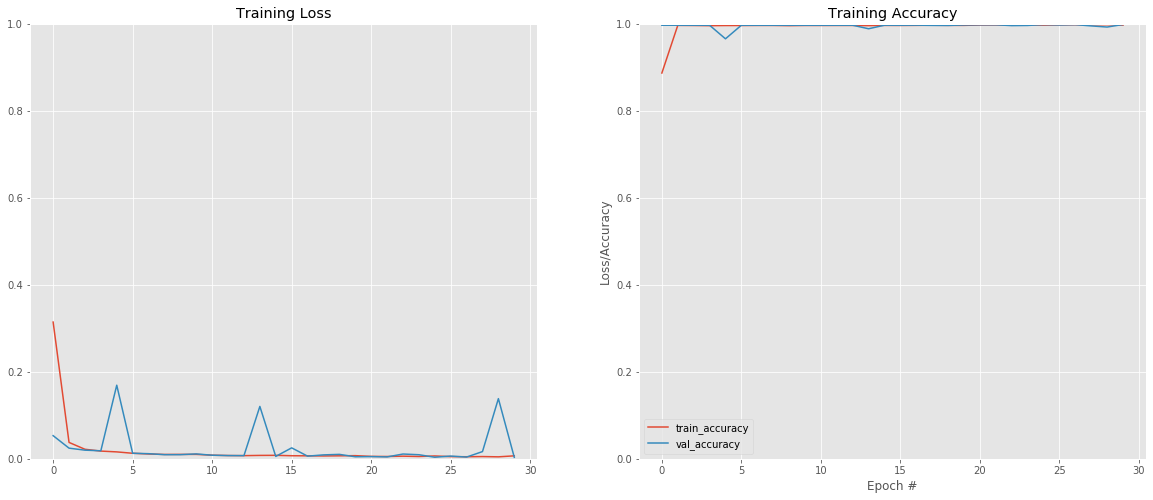

In [0]:
# Get actual number of epochs model was trained for
N = len(result.history['loss'])

#Plot the model evaluation history
plt.style.use("ggplot")
fig = plt.figure(figsize=(20,8))

fig.add_subplot(1,2,1)
plt.title("Training Loss")
plt.plot(np.arange(0, N), result.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), result.history["val_loss"], label="val_loss")
plt.ylim(0, 1)

fig.add_subplot(1,2,2)
plt.title("Training Accuracy")
plt.plot(np.arange(0, N), result.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), result.history["val_accuracy"], label="val_accuracy")
plt.ylim(0, 1)

plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

In [0]:
def read_img(location, not_mask):
    if not_mask == 1:
        img = cv2.imread(location)[:, :, ::-1]
    else:
        img = cv2.imread(location)[:, :, 0]
        img = cv2.imread(location, 0)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_NEAREST)
    img = img.astype(np.float32)
    img = img / 255.0
    if not_mask == 1:
        img = img[np.newaxis]
    return img

In [0]:
def plot_predictions(model, test_image_location, test_mask_location):

    y_true = read_img(location=mask_loc, not_mask=0)
    y_pred = model.predict(read_img(location=img_loc, not_mask=1))[0].argmax(axis=2)
    fig = plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(read_img(img_loc, not_mask=1)[0])
    plt.axis("off")
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(y_true)
    plt.axis("off")
    plt.title("True Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(y_pred)
    plt.axis("off")
    plt.title("Prediction")
    plt.show()

In [0]:
mask_loc = path_val_annotations + os.listdir(path_val_annotations)[2]
img_loc = path_val_images + os.listdir(path_val_images)[2]

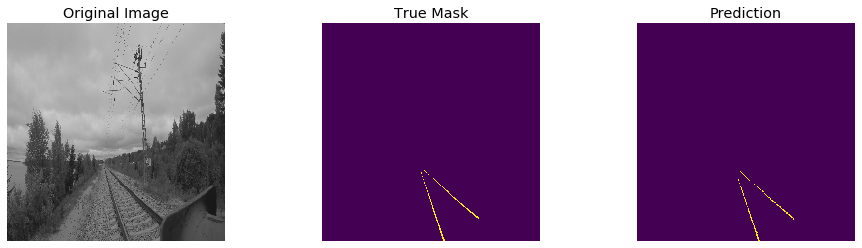

In [0]:
plot_predictions(model, img_loc, mask_loc)

In [0]:
preds_test = model.predict(d, verbose=1)

5/5 [==============================] - 0s 5ms/sample


In [0]:
preds_test_t = (preds_test > 0.5).astype(np.uint8)

5
1


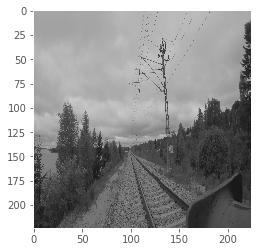

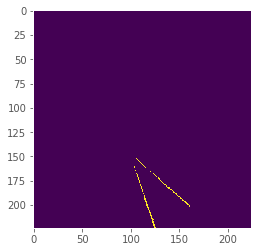

In [0]:
print(len(preds_test_t))
ix = 1
print(ix)
plt.grid(b=None)
imshow(np.squeeze(d[ix]))
plt.show()
plt.grid(b=None)
imshow(np.squeeze(preds_test_t[ix]).argmax(axis=2))
plt.show()

In [0]:
print(np.squeeze(preds_test_t[1]).shape)
print(np.squeeze(preds_test_t[1])[0][0])

(224, 224, 2)
[1 0]


5
2


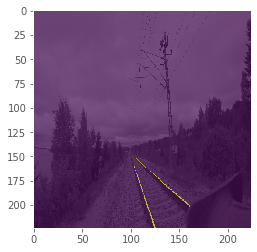

In [0]:
print(len(preds_test_t))
ix = 2
print(ix)
plt.grid(b=None)
plt.imshow(np.squeeze(d[ix]))
plt.imshow(np.squeeze(preds_test_t[ix].argmax(axis=2)),alpha=0.6)

In [0]:
image_path_test = '/content/drive/My Drive/data/-01501.png'
mask_path_test = '/content/drive/My Drive/data/-01501_object.png'

In [0]:
img = cv2.imread(image_path_test)

In [0]:
img.shape

(224, 224, 3)

In [0]:
prcimg = cv2.resize(img,(224, 224), interpolation = cv2.INTER_CUBIC)

In [0]:
prcimg.shape

(224, 224, 3)